In [ ]:
import cv2
import numpy as np
from IPython import get_ipython
import matplotlib.pyplot as plt
import os
import random
import gc
import seaborn as sns
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
Epocas = 50
TotalTreino = 100
#Numero de colunas a serem exibidas as imagens
columns = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
train_dir = "/content/drive/MyDrive/tcc/arquivos/train"

In [ ]:
train_img = []
for train in os.listdir(train_dir):
  train_muda = [train_dir+"/"+train+"/"+img for img in os.listdir(train_dir+"/"+train)]
  train_img += train_muda[:TotalTreino]

In [ ]:
print(len(train_img))

In [ ]:
random.shuffle(train_img)

In [ ]:
nrows = 180
ncolumns = 120
channels = 3  #change to 1 if you want to use grayscale image

In [ ]:
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels

        if 'CARAIBA' in image:
            y.append(0)
        elif 'GUARITA' in image:
            y.append(1)
        elif 'IPE_AMARELO' in image:
            y.append(2)
        
        print(len(y))

    return X, y

In [ ]:
X, y = read_and_process_image(train_img)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rótulos para mudas:')

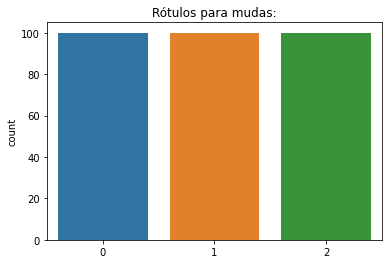

In [ ]:
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Rótulos para mudas:')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (240, 120, 180, 3)
Shape of validation images is: (60, 120, 180, 3)
Shape of labels is: (240,)
Shape of labels is: (60,)


In [ ]:
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 16

print(ntrain, nval)

240 60


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential

num_classes = 3
#layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 120, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3),  activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3),  activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3),  activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#Lets see our model
model.summary()
#softmax

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 178, 118, 32)      896       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 89, 59, 32)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 87, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 43, 28, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 41, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 20, 13, 64)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 18, 11, 128)     

In [ ]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale


#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
print("Train Generator", len(train_generator))
print("Val Generator", len(val_generator))

In [ ]:
#100 steps per epoch
Epocas = 50

history = model.fit_generator(train_generator, steps_per_epoch=ntrain // batch_size, epochs=Epocas, validation_data=val_generator, validation_steps=nval // batch_size)
model.save('modelo.h5')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
15/15 [==============================] - 2s 81ms/step - loss: 1.1074 - accuracy: 0.3083 - val_loss: 1.0991 - val_accuracy: 0.4167
Epoch 2/50
15/15 [==============================] - 1s 76ms/step - loss: 1.1012 - accuracy: 0.3000 - val_loss: 1.0983 - val_accuracy: 0.3125
Epoch 3/50
15/15 [==============================] - 1s 76ms/step - loss: 1.0992 - accuracy: 0.3417 - val_loss: 1.1003 - val_accuracy: 0.3125
Epoch 4/50
15/15 [==============================] - 1s 75ms/step - loss: 1.0919 - accuracy: 0.4333 - val_loss: 1.0451 - val_accuracy: 0.6042
Epoch 5/50
15/15 [==============================] - 1s 75ms/step - loss: 1.0776 - accuracy: 0.3917 - val_loss: 1.0975 - val_accuracy: 0.3542
Epoch 6/50
15/15 [==============================] - 1s 77ms/step - loss: 1.1055 - accuracy: 0.3083 - val_loss: 1.0945 - val_accuracy: 0.2917
Epoch 7/50
15/15 [==============================] - 1s 75ms/step - loss: 1.0273 - accuracy: 0.4292 - val_loss: 0.8663 - val_accuracy: 0.6250
Epoch 8/50
15

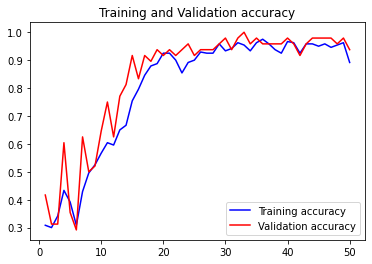

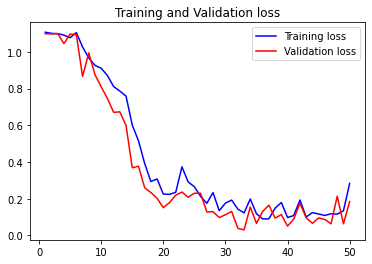

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
